<a href="https://colab.research.google.com/github/Rishabh672003/stack-overflow-label-predictor/blob/main/Stack_Overflow_label_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
url = "https://github.com/Rishabh672003/stack-overflow-label-predictor/raw/main/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')
!rm -rf stack_overflow_16k/train/javascript
!rm -rf stack_overflow_16k/test/javascript
dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6057178/6057178 [==============================] - 0s 0us/step


In [3]:
os.listdir(dataset_dir)

['test', 'train', 'README.md']

In [4]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['csharp', 'python', 'java']

In [5]:
sample_file = os.path.join(train_dir, 'csharp/1.txt')
with open(sample_file) as f:
  print(f.read())

"get the y axis height of webbrowser control document i am trying to get the height of a document in a web browser control...at the moment i'm using the code below but it always returns 622 and i know my documents are all different sizes...private void webcomparesql_documentcompleted(object sender, webbrowserdocumentcompletedeventargs e).        {.            htmldocument htmldoc = webcomparesql.document;.           int scrollhight = htmldoc.window.position.y;.        }...can someone please show me the right way to do this?"



In [6]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

Found 6000 files belonging to 3 classes.
Using 4800 files for training.


In [7]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"what\'s the difference between function and function() in blank? for example, .    thread t = new thread(function);.why not.    thread t = new thread(function());.thank you."\n'
Label 0
Review b'"creating a json parsing function with blank i have been trying to create a function to use as an importable tool for parsing json. here is my code i have so far..#json parser.def jsonimporter(file_path , env_to_return):.    import json.    a = open(file_path,""r"") #opens and sets the file to read..    data = a.read()         #sets variable to read function.    print(data)..    json_data = json.loads(data) #loads the json data and stores it in json_data variable...    print(json_data).    json_data.get(env_to_return)..    return json_data...what my issue is, is that when i call the function in another file it does not display the parsed json it just displays the json as a a dict in this form;..{u\'environments\': [{u\'dev\': [u\'111\', u\'222\']}, {u\'qa\': [u\'333\', u\'444\']}, {u\

In [8]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])
print("Label 2 corresponds to", raw_train_ds.class_names[2])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to python


In [9]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

Found 6000 files belonging to 3 classes.
Using 1200 files for validation.


In [10]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'stack_overflow_16k/test',
    batch_size=batch_size)

Found 6000 files belonging to 3 classes.


In [11]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [12]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [13]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [14]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [15]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"asynchronous parallel threads i want to run a function asynchronously in parallel for all the objects in a collection..here\'s the current code snippet...parallel.foreach(objs,.                new paralleloptions { maxdegreeofparallelism = 10 },.                item =&gt;.            {.                dosomething(someparameter, item);.            });...how can i achieve this is with async-parallel threads"\n', shape=(), dtype=string)
Label csharp
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[8756, 2227, 1093,    3,   45,    4,  129,    5,   88, 4980,    6,
        2227,   10,   75,    2,  230,    6,    5,    1,    2,  228,   31,
           1,   14,    1,    1,  140,  225,   76,    1,  225,   27,   38,
           3,  726,   13,    7,   26,    1, 1093,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0

In [16]:
print("128 ---> ",vectorize_layer.get_vocabulary()[128])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

128 --->  why
 313 --->  words
Vocabulary size: 10000


In [17]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [18]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [19]:
embedding_dim = 16

In [20]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(3)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
Total params: 160051 (625.20 KB)
Trainable params: 160051 (625.20 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [21]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=["accuracy"])

In [22]:
epochs = 25
r = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/25
150/150 [==============================] - 3s 12ms/step - loss: 1.0929 - accuracy: 0.4135 - val_loss: 1.0857 - val_accuracy: 0.4958
Epoch 2/25
150/150 [==============================] - 1s 6ms/step - loss: 1.0720 - accuracy: 0.5448 - val_loss: 1.0581 - val_accuracy: 0.6067
Epoch 3/25
150/150 [==============================] - 1s 6ms/step - loss: 1.0346 - accuracy: 0.6146 - val_loss: 1.0148 - val_accuracy: 0.6392
Epoch 4/25
150/150 [==============================] - 1s 6ms/step - loss: 0.9830 - accuracy: 0.6525 - val_loss: 0.9627 - val_accuracy: 0.6542
Epoch 5/25
150/150 [==============================] - 1s 6ms/step - loss: 0.9252 - accuracy: 0.6894 - val_loss: 0.9089 - val_accuracy: 0.6758
Epoch 6/25
150/150 [==============================] - 1s 6ms/step - loss: 0.8686 - accuracy: 0.7198 - val_loss: 0.8584 - val_accuracy: 0.6992
Epoch 7/25
150/150 [==============================] - 1s 6ms/step - loss: 0.8143 - accuracy: 0.7425 - val_loss: 0.8127 - val_accuracy: 0.7192
Epoch

In [23]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

188/188 [==============================] - 1s 4ms/step - loss: 0.5055 - accuracy: 0.8032
Loss:  0.5054749846458435
Accuracy:  0.8031666874885559


In [24]:
history_dict = r.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

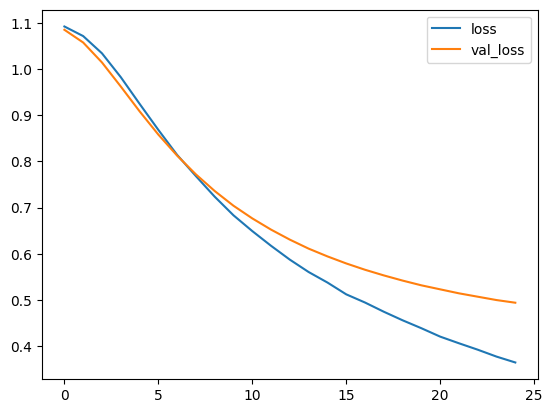

In [25]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

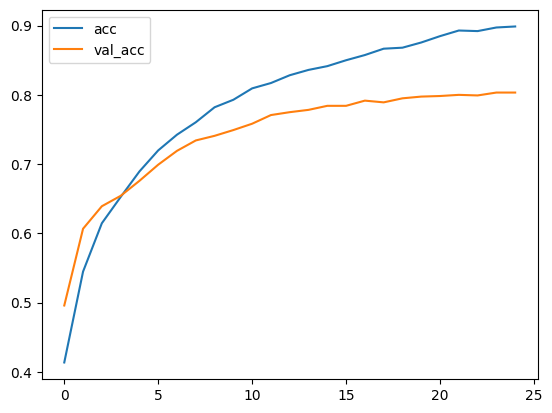

In [26]:
plt.plot(r.history['accuracy'], label = "acc")
plt.plot(r.history['val_accuracy'], label = "val_acc")
plt.legend();

In [27]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


188/188 [==============================] - 1s 5ms/step - loss: 0.5055 - accuracy: 0.8032
0.8031666874885559


In [28]:
labels = ["Csharp", "Java", "Python"]
examples = [
  "Why can't this generic method return concrete class that implements it's interface?",
  "What I wish I had known about single page applications?",
  "Restsharp 110.2 returns 401 with Basic Authentication",
  "Im having trouble with open cv2, im still learning but i keep getting stuck in the imshow function",
]

answers = export_model.predict(examples)
print(answers)
for i in range(0,len(examples)):
  label = np.argmax(answers[i])
  print(labels[label])

1/1 [==============================] - 0s 137ms/step
[[0.5944403  0.6574719  0.28684664]
 [0.5738939  0.52254957 0.41169068]
 [0.5486597  0.49084464 0.46480483]
 [0.49763307 0.41060677 0.5985944 ]]
Java
Csharp
Csharp
Python


In [29]:
export_model.save('./NLP-model')
!tar -czf ./NLP-model.tar.gz ./NLP-model

188/188 [==============================] - 2s 8ms/step
[[697 581 722]
 [620 639 741]
 [663 616 721]]


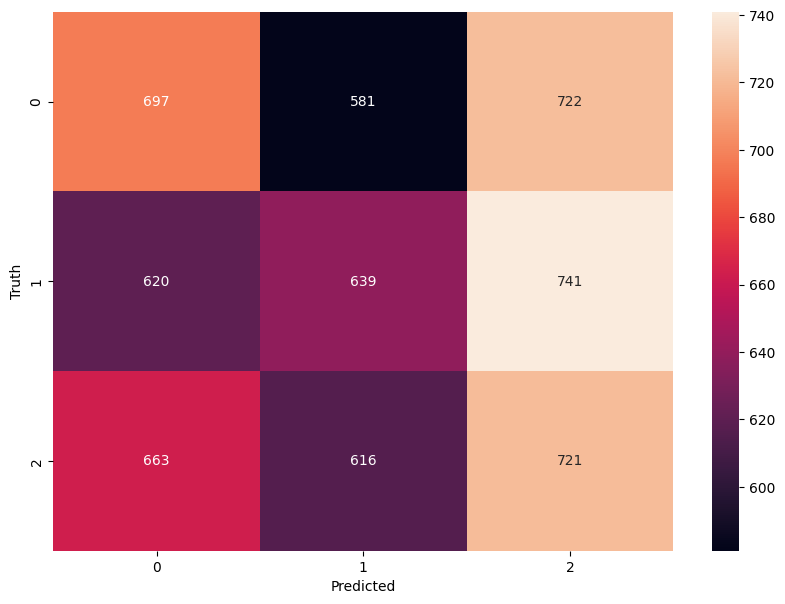

In [30]:
predictions = export_model.predict(raw_test_ds)

predicted_labels = np.argmax(predictions, axis=-1)

actual_labels = []
for _, label in raw_test_ds:
  actual_labels.extend(label.numpy())

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(actual_labels, predicted_labels).numpy()

# Print the confusion matrix
print(confusion_mtx)

# Plot the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(confusion_mtx, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()
